In [1]:
#Import necessary libraries 
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pygraphviz
import matplotlib.colors as mcolors
import scipy.sparse
import scipy.sparse.linalg as sc
import numpy.typing as npt
import random as rd
import sklearn.cluster as sk
from sympy import Matrix
from sklearn.cluster import KMeans
import utils

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Question 1
Max-Flow for bipartite graphs:Python/NetworkX question<br> <br>
The Davis Southern women social network is a dataset collected in the 1930s. It contains the observed attendance at 14 social events by 18 Southern women. It can be accessed on networkX

### Part a
Plot this graph in a bipartite layout (e.g., the left figure on Page 35 in Lecture 3).

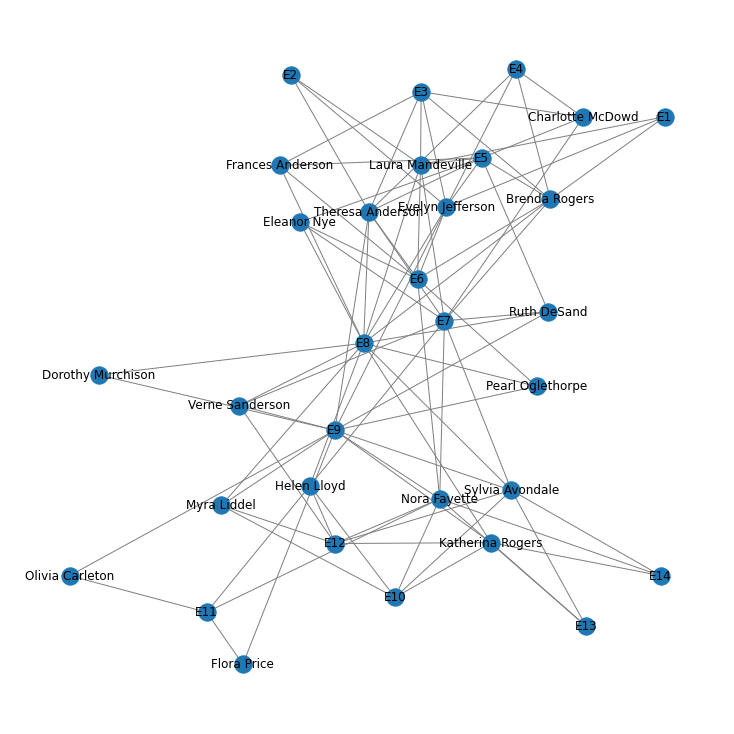

In [2]:
#Imports the Davis Southern Women Graph 
davis = nx.davis_southern_women_graph()

#Draws the Davis Southern Women Graph
plt.figure(figsize = (10,10))
nx.draw(davis, with_labels = True, edge_color = "grey")
plt.show()

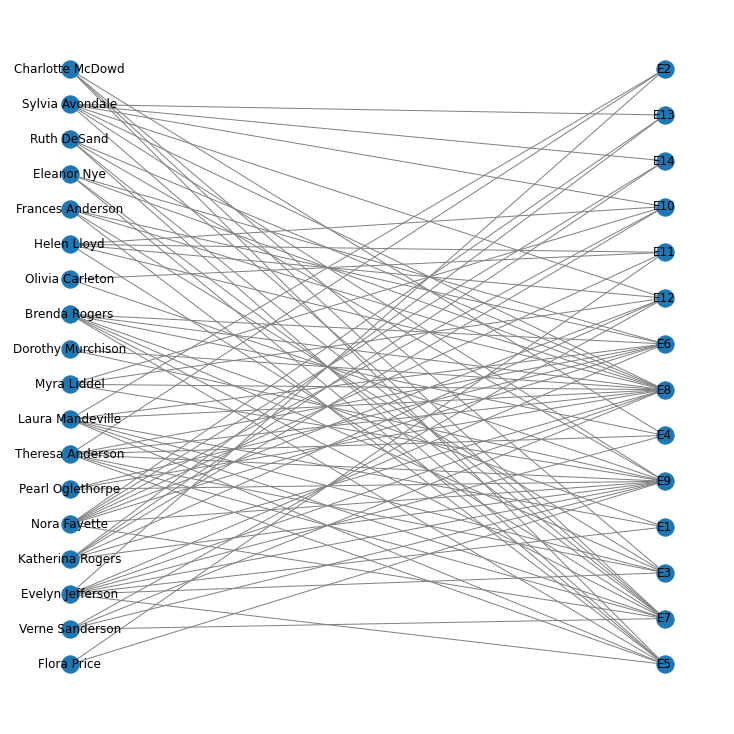

In [3]:
women = davis.graph["top"]

pos = nx.bipartite_layout(davis, women)

# Pass that layout to nx.draw
plt.figure(figsize = (10,10))
nx.draw(davis,pos, with_labels = True, edge_color = "grey")
plt.show()

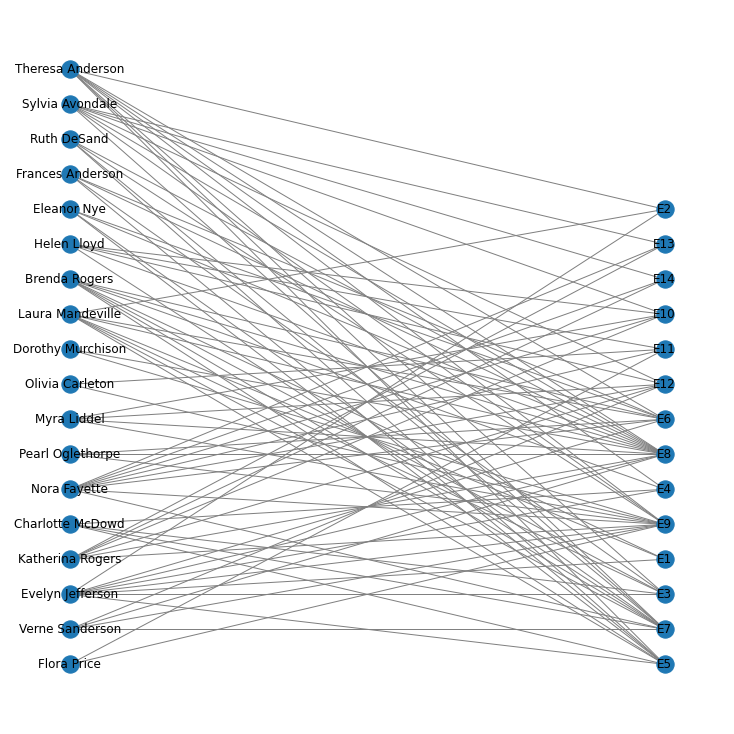

In [4]:
#Plots the network in the same layout as Page 35 in Lecture 3

#Isolates the two node lists from the Davis Southern Women Graph
l, r = nx.bipartite.sets(davis)

#Creates an empty position
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

#Draws the graph 
plt.figure(figsize = (10,10))
nx.draw(davis, pos=pos, with_labels = True, edge_color = "grey")
plt.show()

#This looks ugly and will not be the final form

### Part b 
Plot the graph that links the women that have been in the same social event.
Hint: If you look at Lecture 3 slide 42, you can understand that the off-diagonal non-zero entries of $A^2$ are what you are looking for...


/var/folders/87/6bfjhdg13952r0hbf93s28b40000gn/T/ipykernel_37437/651768506.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = np.square(nx.adjacency_matrix(davis)).todense()


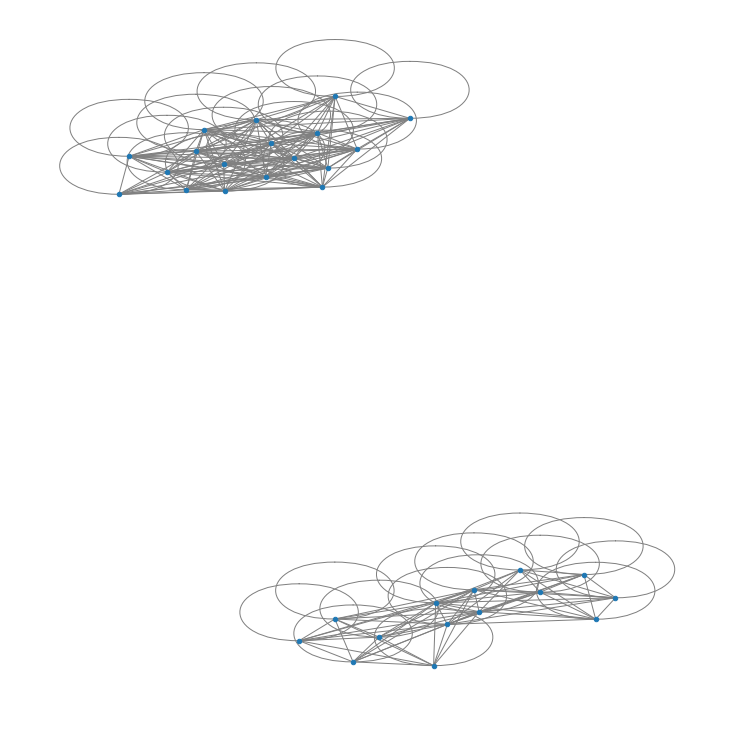

In [5]:
A1 = np.square(nx.adjacency_matrix(davis)).todense()

A2= nx.from_numpy_matrix(A1)
plt.figure(figsize = (10,10))
nx.draw(A2, node_size = 20, edge_color = "grey")
plt.show()

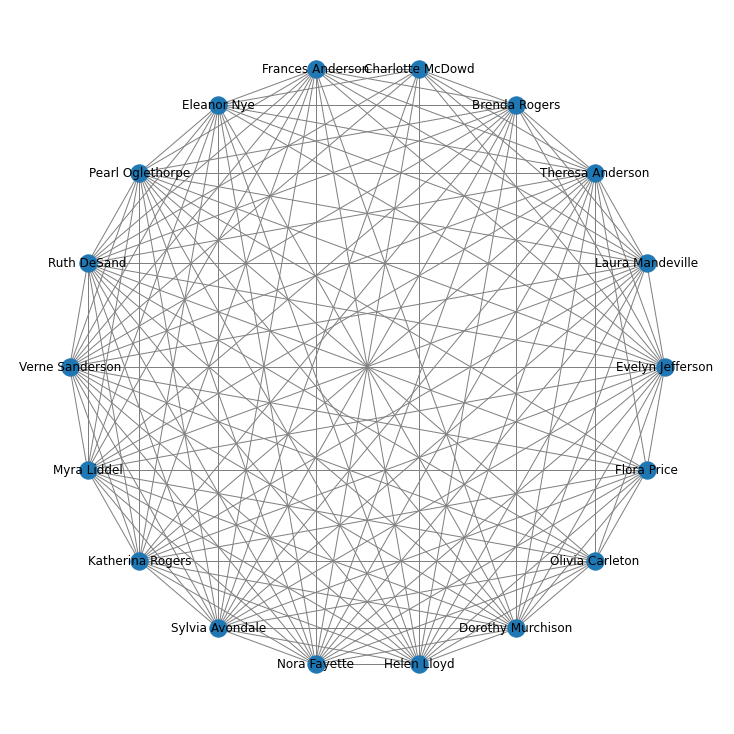

In [6]:
#Imports the bipartite module from Networkx
import networkx.algorithms.bipartite as bipartite

#Defines davis as G for simplicity
G =davis 

#Creates two different groups for graphign
women = G.graph["top"]
clubs = G.graph["bottom"]

#Defines W to graph it 
W = bipartite.projected_graph(G, women)

#Graphs W
plt.figure(figsize = (10,10))
nx.draw_circular(W, with_labels = True,edge_color = "grey")
plt.show()

### Part c

Plot the graph of the social events where one or more guests were the same.
Hint: same suggestion as the previous one.

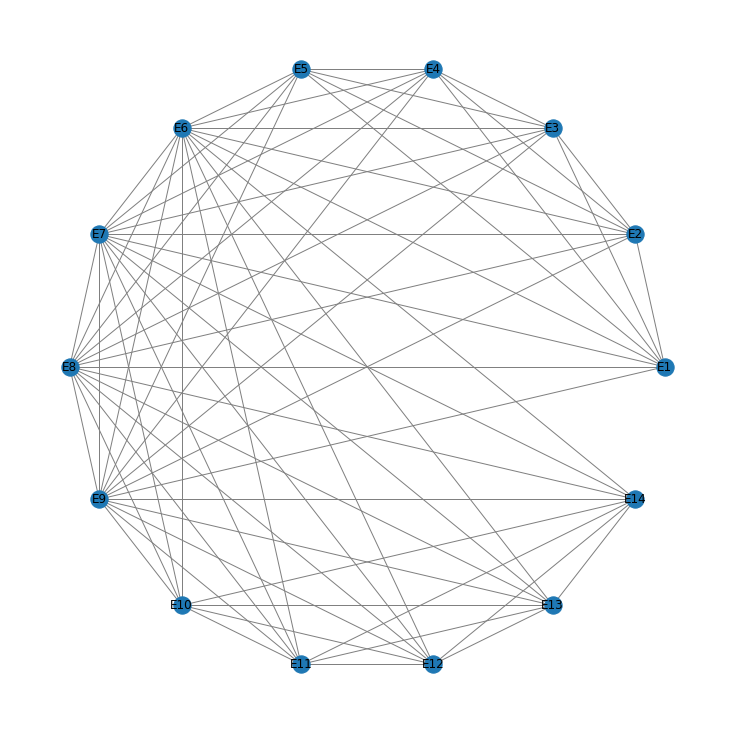

In [7]:
#Defines C using the newly seperated groups 
C = bipartite.projected_graph(G, clubs)

#Draws C
plt.figure(figsize = (10,10))
nx.draw_circular(C, with_labels = True, edge_color = "grey")
plt.show()

### Part d

Suppose that instead of social events, in the “Davis Southern Women Graph”  the events are individual parking spaces available for EV charging, and that each woman can reach the spaces at about the same time. Let the weight, $wab$, on $edge (a, b)$ indicate the distance to destination of woman $a$ from parking space $b$.
By setting $wab = 1$ for all $(a, b) ∈ E$ , answer the following questions:

#### i 

Indicate the number of women that will not be able to park and charge their car.

In [8]:
#Prints the number of women who will not have a parking spot
#Takes the difference of the length between the two groups (women and clubs)
print("There will be",len(women)-len(clubs),"who cannot park their electric cars.")

There will be 4 who cannot park their electric cars.


#### ii
Convert the graph into a flow network using the steps highlighted in the introduction. Set the capacity of all the new edges to 1 and their weights to 0. Plot the flow network.

1. Convert the graph edges to a directed edges going from $A$ to $B$.
2. Add a source node $s$ and a destination node $t$.
3. Draw edges from $s$ to each node in $A$ and from each node in $B$ to $t$.
4. Set capacity $fa,b = 1$ for each edge in the new graph.

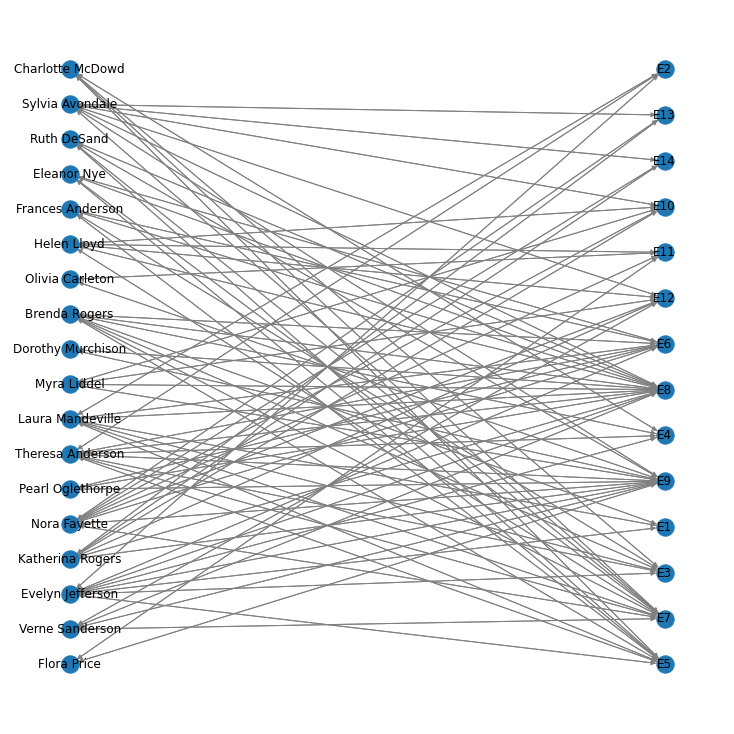

In [9]:
women = davis.graph["top"]

ddavis = nx.DiGraph(nx.davis_southern_women_graph())

nx.set_edge_attributes(ddavis, values = 1, name = 'weight')
pos = nx.bipartite_layout(ddavis, women)

# Pass that layout to nx.draw
plt.figure(figsize = (10,10))
nx.draw(ddavis,pos, with_labels = True, edge_color = "grey")
plt.show()

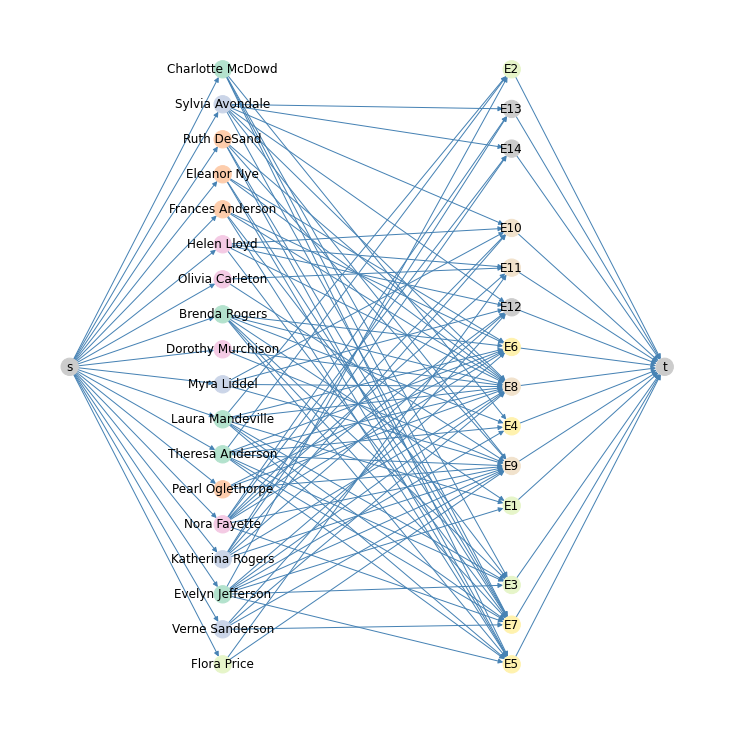

In [10]:
#Makes the grpah
Dig = nx.DiGraph()

#Adds the nodes and edges from previous graph
Dig.add_nodes_from(davis)
Dig.add_edges_from(davis.edges)


#Make previous edge weights equal to one
previous_edge = davis.edges
for i in previous_edge:
    nx.set_edge_attributes(Dig,(i,1), "weight")

#Add new edges from s to women and from clubs to t with weight 0 and capacity 1
for i in women:
    Dig.add_edge("s",i, capacity = 1, weight = 0)
    
for i in clubs:
    Dig.add_edge(i, "t",capacity = 1, weight = 0)
    

#Graph out the new flow_network
pos = utils.flow_layout(Dig, "s", "t")
nx.set_node_attributes(Dig, pos , "pos")
plt.figure(figsize = (10,10))
nx.draw(Dig, pos=pos, with_labels = True , edge_color = "#4682b4", node_color = range(len(Dig)) , cmap = plt.cm.Pastel2)
edges_to_highlight = {edge: capacity for edge , capacity in nx.
    get_edge_attributes(
    Dig, "capacity").items () if any(node in ["s", "t"] for node
    in edge)}


#### iii 
Find the maximum bipartite matching for this graph using the flow network from the
previous step.

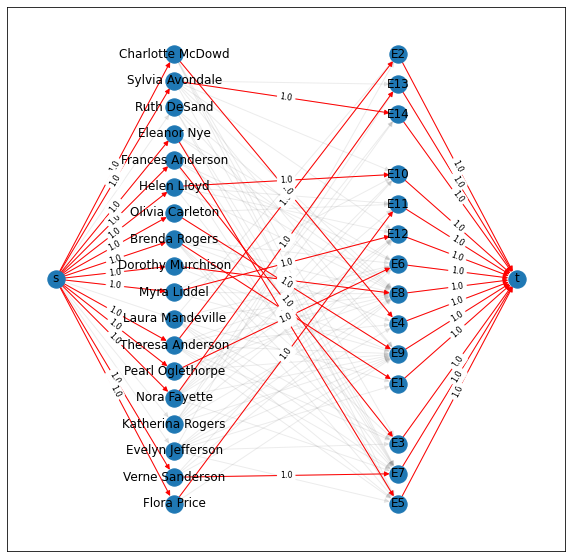

In [11]:
#Use maxflow on the network 
flowVal , flowDict = nx.maximum_flow(Dig, "s", "t", capacity= "capacity")
utils.draw_flow(Dig, flowDict , {"figsize":(10, 10)}, {"font_size": 8})

### Part e 
Generate random weights for each link between the women and the parking spaces. These represent the distances. You can use a Rayleigh distribution for each (woman, spot) pair in the edge set using the function numpy.random.rayleigh. <br>
<div style="text-align: left">
        import numpy <br>
        scale = 1 <br>
        size = size = G.number_of_edges() <br>
        distances = numpy.random.rayleigh(scale=scale, size = size) <br>
        </div>

#### i 
Convert the graph into a flow network using the steps highlighted in the introduction. Set the capacity of all the new edges to 1 and their weights to 0.

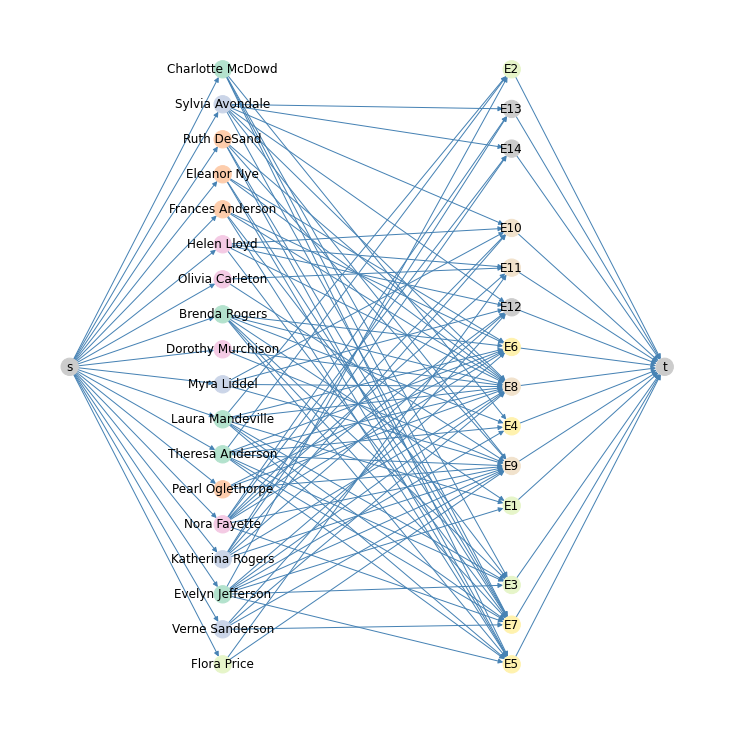

In [49]:
#Makes the grpah
DigR = nx.DiGraph()

#Adds the nodes and edges from previous graph
DigR.add_nodes_from(davis)
DigR.add_edges_from(davis.edges)

#Make previous edge weights equal to the Rayleigh Distribution

scale = 1
size = davis.number_of_edges()
distances = np.random.rayleigh(scale=scale, size = size)

previous_edge = davis.edges
for i , j in previous_edge :
    for k in range(len(previous_edge)) :
        DigR.add_edge(i,j,capacity = 1 , weight = distances[k ]*10)


# Make previous edge weights equal to one


for j in range ( davis . number_of_edges () ):
    nx . set_edge_attributes ( DigR , dict ((i , distances [ j ]) for i in
previous_edge ) , " weight ")
    
    
#Add new edges from s to women and from clubs to t with weight 0 and capacity 1
for i in women:
    DigR.add_edge("s",i, capacity = 1, weight = 0)
    
for i in clubs:
    DigR.add_edge(i, "t",capacity = 1, weight = 0)



#Graph out the new flow_network
pos = utils.flow_layout(DigR, "s", "t")
nx.set_node_attributes(DigR, pos , "pos")
plt.figure(figsize = (10,10))
nx.draw(DigR, pos=pos,with_labels = True , edge_color = "#4682b4", node_color = range(len(DigR)) , cmap = plt.cm.Pastel2)
edges_to_highlight = {edge: capacity for edge , capacity in nx.
    get_edge_attributes(
    DigR, "capacity").items () if any(node in ["s", "t"] for node
    in edge)}


In [23]:
previous_edge = davis.edges
print(previous_edge)

[('Evelyn Jefferson', 'E1'), ('Evelyn Jefferson', 'E2'), ('Evelyn Jefferson', 'E3'), ('Evelyn Jefferson', 'E4'), ('Evelyn Jefferson', 'E5'), ('Evelyn Jefferson', 'E6'), ('Evelyn Jefferson', 'E8'), ('Evelyn Jefferson', 'E9'), ('Laura Mandeville', 'E1'), ('Laura Mandeville', 'E2'), ('Laura Mandeville', 'E3'), ('Laura Mandeville', 'E5'), ('Laura Mandeville', 'E6'), ('Laura Mandeville', 'E7'), ('Laura Mandeville', 'E8'), ('Theresa Anderson', 'E2'), ('Theresa Anderson', 'E3'), ('Theresa Anderson', 'E4'), ('Theresa Anderson', 'E5'), ('Theresa Anderson', 'E6'), ('Theresa Anderson', 'E7'), ('Theresa Anderson', 'E8'), ('Theresa Anderson', 'E9'), ('Brenda Rogers', 'E1'), ('Brenda Rogers', 'E3'), ('Brenda Rogers', 'E4'), ('Brenda Rogers', 'E5'), ('Brenda Rogers', 'E6'), ('Brenda Rogers', 'E7'), ('Brenda Rogers', 'E8'), ('Charlotte McDowd', 'E3'), ('Charlotte McDowd', 'E4'), ('Charlotte McDowd', 'E5'), ('Charlotte McDowd', 'E7'), ('Frances Anderson', 'E3'), ('Frances Anderson', 'E5'), ('Frances An

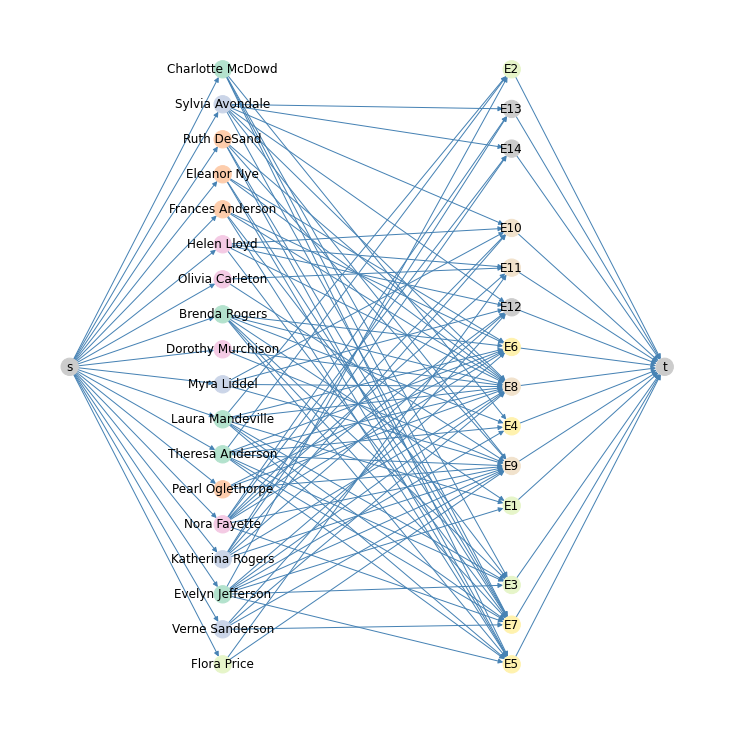

In [56]:
dq = nx.DiGraph()
dq.add_nodes_from(davis)

previous_edge = davis.edges

for i , j in previous_edge:
    for k in range(len(previous_edge)):
        dq.add_edge(i, j,capacity = 1, weight = distances[k])


#Add new edges from s to women and from clubs to t with weight 0 and capacity 1
for i in women:
    dq.add_edge("s",i, capacity = 1, weight = 0)
    
for i in clubs:
    dq.add_edge(i, "t",capacity = 1, weight = 0)



#Graph out the new flow_network
pos = utils.flow_layout(dq, "s", "t")
nx.set_node_attributes(dq, pos , "pos")
plt.figure(figsize = (10,10))
nx.draw(dq, pos=pos,with_labels = True , edge_color = "#4682b4", node_color = range(len(dq)) , cmap = plt.cm.Pastel2)
edges_to_highlight = {edge: capacity for edge , capacity in nx.
    get_edge_attributes(
    dq, "capacity").items () if any(node in ["s", "t"] for node
    in edge)}

#### ii 
Find the maximum bipartite matching that minimizes the average of distances of the edges in it. <br><br>
Useful methods: networkx.max flow min cost

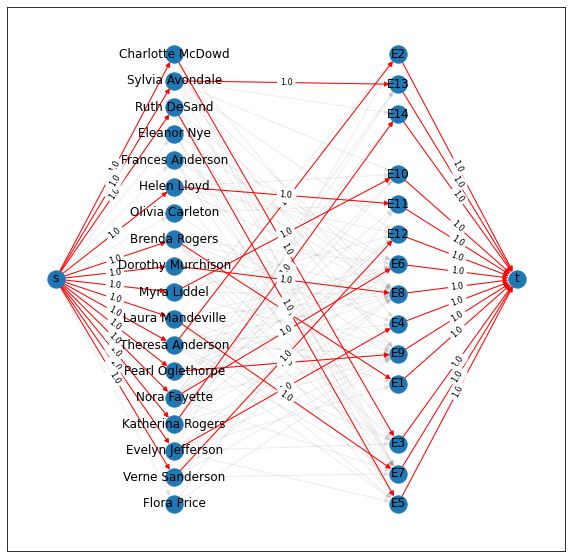

In [57]:
#Use maxflow on the network 
flowDict2 = nx.max_flow_min_cost(dq, "s", "t", weight = "weight", capacity = "capacity")
utils.draw_flow(dq, flowDict2 , {"figsize":(10, 10)}, {"font_size": 8})

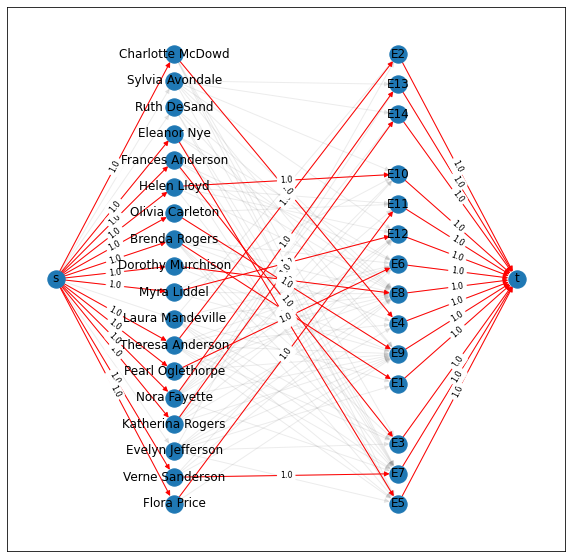

In [26]:
#Use maxflow on the network 
flowVal , flowDict = nx.maximum_flow(dq, "s", "t", capacity= "capacity")
utils.draw_flow(dq, flowDict , {"figsize":(10, 10)}, {"font_size": 8})

## Question 2

(1–2 points) Spectral Clustering:Python/NetworkX question<br> <br>
In this problem, we want to apply spectral clustering methods to the Davis Southern women social network. We want to find the groups of people that attend similar events (a group of friends). For this problem, use the bipartite graph only (DO NOT use the women’s graph or the events’ graph)

### Part a
Calculate the degree of the women, and the degree of the events. What women have the most socially active life? What are the most popular events?

In [ ]:
#Finds the degree for the women 
for w in women:
    print(f"{w} {davis.degree(w)} ")


In [ ]:
#Finds the degree for the social clubs
for c in clubs:
    print(f" {c} {davis.degree(c)}")
    

### Part b

Compute the eigenvector centrality and the betweeness centrality of the graph. What do you observe

In [ ]:
#Finds the degree centrality of the Davis Southern Women Graph
nx.degree_centrality(davis)

In [ ]:
#Finds the eigenvector centrality of the Davis Southern Women Graph
nx.eigenvector_centrality(davis)

In [ ]:
#Finds the betweenness centrality of the Davis Southern Women Graph
nx.betweenness_centrality(davis)

Popularity != importance 

### Part c 

Find the eigenvectors and eigenvalues of the Laplacian of the graph. Plot the eigenvalues in ascending order.

In [ ]:
#Find the eigenvectors and eigenvalues of the Laplacian of the graph. Plot the eigenvalues in ascending order.
def plotL():
    #Finds the laplacian matrix of the davis social group
    L = nx.laplacian_matrix(davis).todense().astype(float)
    
    #Finds the eigenvalues and eigenvectors of the laplacian matrix
    evals,evecs = np.linalg.eig(L)
    
    svals = evals
    #sorts the laplacian eigenvalues
    svals.sort()
    
    Num = []
    Val = []
    
    for i in range(len(svals)):
        Num.append(i)
        Val.append(svals[i])
        
    plt.plot(Num, Val) 

plotL()

### Part d
 Use spectral clustering to cluster the network. Use three clusters and plot the results. (Hint: You may want to use k-means to do the clustering. Also, please use a different color for each cluster. Below, you will find a solution to the clustering problem). What do you observe? Comment your results

In [ ]:
#Plots for fun the circular graph of the Davis Southern Women Graph

nx.draw_circular(davis, with_labels=True, edge_color = "grey")


In [ ]:
#Finds the adjacency matrix for the Davis Southern Women Graph
A1=nx.adjacency_matrix(davis).todense()

#Prints out the adjacency matrix for the Davis Southern Women Graph
A1

## Useful Information and Random Code Shennagins 

In [ ]:
#Plot the graph that links the women that have been in the same social event.
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.bipartite as bipartite

G = nx.davis_southern_women_graph()
women = G.graph["top"]
clubs = G.graph["bottom"]

print("Biadjacency matrix")
print(bipartite.biadjacency_matrix(G, women, clubs))

# project bipartite graph onto women nodes
W = bipartite.projected_graph(G, women)
print()
print("#Friends, Member")
for w in women:
    print(f"{W.degree(w)} {w}")

# project bipartite graph onto women nodes keeping number of co-occurence
# the degree computed is weighted and counts the total number of shared contacts
W = bipartite.weighted_projected_graph(G, women)
print()
print("#Friend meetings, Member")
for w in women:
    print(f"{W.degree(w, weight='weight')} {w}")

pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos)
plt.show()

In [ ]:
X = v*w
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=10)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
fig = plt.subplots(1, figsize=(12,10))
colors = ['#d7191c', '#ffffbf', '#2b83ba']
node_colors = [ colors[labels[v]] for v in G.nodes()]
nx.draw(G, node_color=node_colors, with_labels='True')
